# Kaggle 5

## Video Classification (drawing a sword VS using a sword) with PyTorch

Video tutorial (in French) [here](https://www.youtube.com/watch?v=PTQudKynRew).

Two classes: `use_sword` (videos where a sword is used, e.g. `supp_use_sword_100.mkv` in the complete training set) and `sword_drawn` (videos where a sword is drawn, e.g., `supp_drawing_100.mkv` in the complete training set).

In [123]:
list_classes = ["use_sword", "sword_drawn"]

In [124]:
import random
import numpy as np
import torch

# set seeds for reproducibility
SEED = 123
_ = random.seed(SEED)
_ = np.random.seed(SEED)
_ = torch.manual_seed(SEED)

In simple terms, a video is made up of a series of images or frames that are played sequentially. Typically, the videos we encounter in our daily lives consist of more than 30 frames per second, which means that even short videos involve processing a large amount of data compared to image classification. To handle this large amount of data, it's common to skip intermediate frames and process fewer frames per second, as the images in a video are often highly correlated.

The initial step of data preparation therefore involves converting videos into images. For this purpose, we will select only 16 frames from each video that are evenly distributed throughout the video's duration, and then save them as .jpg files. This approach is aimed at reducing the computational complexity of the task.

To facilitate this step, I have developed two helper functions: one to extract frames from the videos (`get_frames`), and another to save them (`store_frames`) as individual image files.

In [125]:
import cv2  # you might need to run `pip install opencv-python`
import os

def get_frames(filename: str, n_frames: int = 16) -> tuple[list, int]:
    """
    :param filename: path to video file
    :param n_frames: number of frames to extract

    :return: list of frames, number of frames in video
    """
    frames = []
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_list= np.linspace(0, v_len-1, n_frames + 1, dtype=np.int16)
    
    assert len(frame_list) == n_frames + 1  # sanity check

    for fn in range(v_len):
        success, frame = v_cap.read()
        if success is False:
            # The variable success is a boolean value that is returned by the cv2.VideoCapture.read function,
            #  which attempts to read the next frame from the video. 
            # - If success is True, it means that the frame was read successfully and the frame variable will contain the 
            #   image data for the next frame of the video. 
            # - If success is False, it means that there are no more frames to read from the video (i.e., we have reached 
            #   the end of the video, should not happen here) or there was an error in reading the frame. 
            # Therefore, the success variable is used in the get_frames function to check if a frame was 
            # successfully read from the video file or not, and if it was not read successfully, 
            # the function continues to the next iteration of the loop to try and read the next frame.
            continue
            # there is usually one frame missing at the end of the video, which is why frame_list is one element longer
        if (fn in frame_list) and (len(frames) < n_frames):
            # when there is no frame missing, the last frame is not added to the list of frames
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frames.append(frame)
    v_cap.release()

    if len(frames) < n_frames:
        print(f'Warning: Could not extract all frames from video {filename}')

    return frames, v_len


def store_frames(frames, path2store) -> None:
    """
    :param frames: list of frames
    :param path2store: path to store frames

    :return: None
    """
    for ii, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  
        path2img = os.path.join(path2store, "frame"+str(ii)+".jpg")
        cv2.imwrite(path2img, frame)

Let's use the helper functions to loop over the videos, extract 16 frames, and store them as jpg files.

In [126]:
EXTENSIONS = [".avi", ".mkv"]
N_FRAMES = 16

PATH2DATA = "./data"
SUB_FOLDER = "videos"
SUB_FOLDER_JPG = "frames"
PATH2ACATGS = os.path.join(PATH2DATA, SUB_FOLDER)
LIST_OF_CATEGORIES = os.listdir(PATH2ACATGS)
LIST_OF_CATEGORIES, len(LIST_OF_CATEGORIES)

(['sword_drawn', 'use_sword'], 2)

In [127]:
def process_videos():
    for root, dirs, files in os.walk(PATH2ACATGS, topdown=False):
        print(root, dirs)
        for name in files:
            if os.path.splitext(name)[1] not in EXTENSIONS:
                print(f"{name} is not a video file")
                continue
            path2vid = os.path.join(root, name)
            frames, vlen = get_frames(path2vid, n_frames = N_FRAMES)
            path2store = path2vid.replace(SUB_FOLDER, SUB_FOLDER_JPG)
            for extension in EXTENSIONS:
                path2store = path2store.replace(extension, "")
            os.makedirs(path2store, exist_ok = True)
            store_frames(frames, path2store)

process_videos()

./data\videos\sword_drawn []
.gitkeep is not a video file
./data\videos\use_sword []
.gitkeep is not a video file
./data\videos ['sword_drawn', 'use_sword']


---

Now that the videos are converted into frames, we are ready to start building our Dataset and DataLoader objects.

In [128]:
import re

# Load the data
def get_vids(path2data = "./data", sub_folder_jpg = "frames"):
    """
    :param path2data: path to data
    :param sub_folder_jpg: subfolder where the frames are stored

    :return: videos (selected frames), list of labels
    """
    X = []
    y = []
    path2aCatgs = os.path.join(path2data, sub_folder_jpg)
    listOfCategories = os.listdir(path2aCatgs)
    for category in listOfCategories:
        category_path = os.path.join(path2aCatgs, category)
        for video in os.listdir(category_path):
            frames = []
            frame_names = os.listdir(os.path.join(category_path, video))
            frame_names.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))
            # otherwise the frames are not in the correct order (e.g. frame0.jpg, frame1.jpg, frame10.jpg, frame11.jpg, frame12.jpg,
            # frame13.jpg, frame14.jpg, frame15.jpg, frame2.jpg, frame3.jpg, frame4.jpg, frame5.jpg, frame6.jpg, frame7.jpg,
            # frame8.jpg, frame9.jpg) which ain't pretty
            for name in frame_names:
                # looping over the frames of the video
                if ".jpg" not in name:
                    continue
                path2img = os.path.join(category_path, video, name)
                img = cv2.imread(path2img)
                # OpenCV uses a default color representation of BGR (Blue, Green, Red) for images,
                # whereas matplotlib expects a color representation of RGB (Red, Green, Blue). 
                # This difference in color representation can cause the colors to appear weird or distorted in the frames.
                # To fix this issue, we can use the cv2.cvtColor() function in OpenCV to convert the color representation
                # of the frames from BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
                frames.append(img)
            if len(frames) != N_FRAMES:
                print(f'Warning: Could not extract all frames from video {video}')
                continue
            X.append(frames)
            y.append(category)
    return X, y

In [129]:
X_train, y_train = get_vids()

In [130]:
y_train = np.array(y_train)
y_train.shape

(99,)

In [131]:
# We cannot transform X into a numpy array because the elements of X are lists of different sizes (frames of different sizes,
# some videos being of better quality than others).
print(len(X_train), len(X_train[0]), len(X_train[0][0]), len(X_train[0][0][0]))  # 99 videos, 16 frames, first video is 240x320
print(len(X_train), len(X_train[5]), len(X_train[5][0]), len(X_train[5][0][0]))  # 99 videos, 16 frames, fifth video is 240x288

99 16 240 320
99 16 240 288


In [132]:
np.max(X_train[10]), np.min(X_train[10])  # the values are integers between 0 and 255, we might want to normalize them, cf. below

(255, 0)

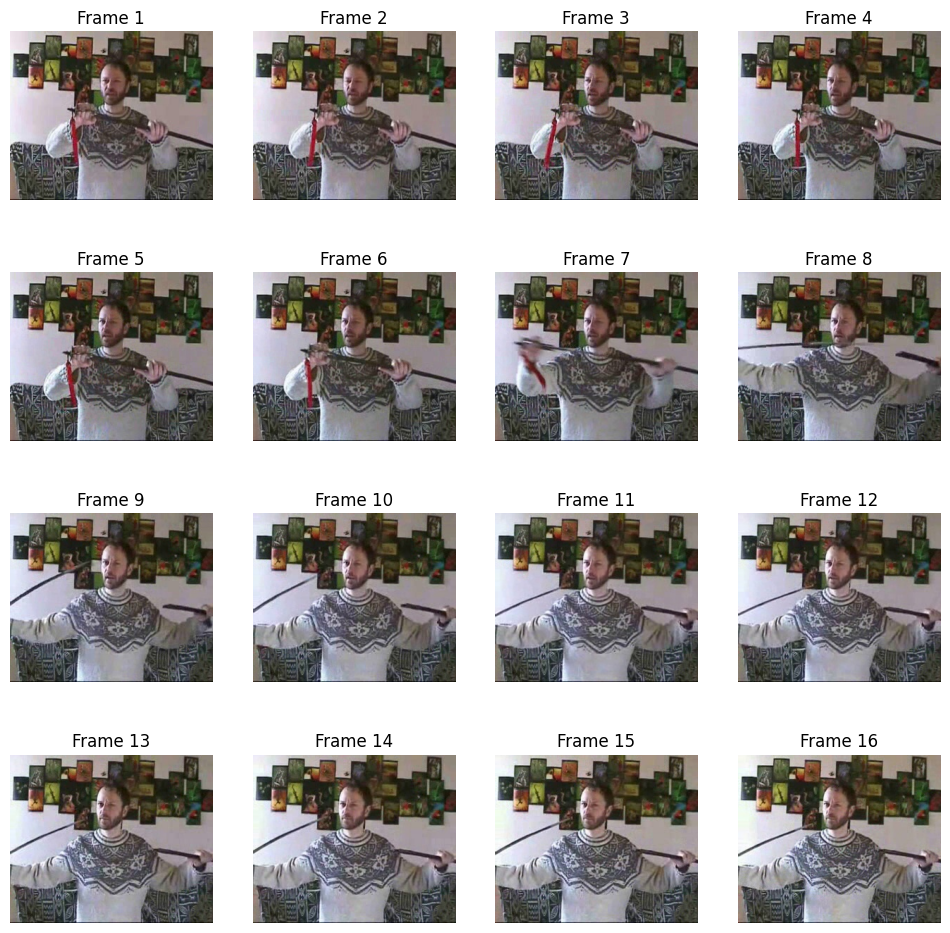

In [133]:
# Draw X_train[5]
import matplotlib.pyplot as plt

def draw_frames(frames, n_frames = 16, n_cols = 4) -> None:
    """
    :param frames: list of frames
    :param n_frames: number of frames to draw
    :param n_cols: number of columns

    :return: None
    """
    fig = plt.figure(figsize=(12, 12))
    for i in range(n_frames):
        ax = fig.add_subplot(4, 4, i+1)
        ax.imshow(frames[i])
        ax.axis('off')
        ax.set_title(f'Frame {i+1}')
    plt.show()

draw_frames(X_train[5])

In [134]:
WIDTH = 112
HEIGHT = 112

In [135]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Custom Compose class to be able to apply the same transformation to all frames in the sequence
class ComposeCustom(transforms.Compose):
    def __init__(self, transforms):
        # No overwrite
        super().__init__(transforms)
    def __call__(self, imgs):
        # Overwrite
        imgs_tr = []
        first: bool = True
        for t in self.transforms:
            if isinstance(t, RandomHorizontalFlipCustom):
                random_nb = torch.rand(1)
                if first:
                    imgs_tr = [t(img, random_nb) for img in imgs]
                    first = False
                else:
                    imgs_tr = [t(img_tr, random_nb) for img_tr in imgs_tr]
            elif isinstance(t, RandomAffineCustom):
                params = t.get_params(t.degrees, t.translate, t.scale, t.shear, (WIDTH, HEIGHT))
                if first:
                    imgs_tr = [t(img, params) for img in imgs]
                    first = False
                else:
                    imgs_tr = [t(img_tr, params) for img_tr in imgs_tr]
            else:
                if first:
                    imgs_tr = [t(img) for img in imgs]
                    first = False
                else:
                    imgs_tr = [t(img_tr) for img_tr in imgs_tr]
        return imgs_tr
# RandomHorizontalFlip needs to be applied consistently to all frames in the sequence
class RandomHorizontalFlipCustom(transforms.RandomHorizontalFlip):
    def __init__(self, p=0.5):
        # No overwrite
        super().__init__(p)
    def forward(self, img, random_nb):
        # Overwrite
        if random_nb < self.p:
            return transforms.functional.hflip(img)
        return img
# RandomAffine needs to be applied consistently to all frames in the sequence
class RandomAffineCustom(transforms.RandomAffine):
    def __init__(self, *args, **kwargs):
        # No overwrite
        super().__init__(*args, **kwargs)
    def forward(self, img, params):
        # Overwrite
        return transforms.functional.affine(img, *params)


class VideoDataset(Dataset):
    def __init__(self, input_, labels, transform=None):
        self.input_ = input_
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.input_)

    def __getitem__(self, idx):
        frames_tr = self.transform(self.input_[idx])  # Apply the same transformation to each frame
        frames_tr = torch.stack(frames_tr)  # Convert the list of transformed frames to a tensor
        # transform labels to tensor
        labels = list_classes.index(self.labels[idx])
        return frames_tr, labels

The code below defines a `train_transformer` object that is a composition of several image transformation functions, including resizing, random horizontal flipping, and normalization. These are commonly used data augmentation techniques when training deep learning models for computer vision tasks.

In [136]:
train_transformer = ComposeCustom(
    [
        transforms.ToTensor(),
        transforms.Resize((WIDTH, HEIGHT), interpolation=transforms.InterpolationMode.BICUBIC),
        RandomHorizontalFlipCustom(p=0.5),
        RandomAffineCustom(degrees=3, translate=(0.05, 0.05), scale=(0.99, 1.01)),
        transforms.Normalize([0.43216, 0.394666, 0.37645], [0.22803, 0.22145, 0.216989]),
    ]
)

In the code above, the Normalize transform is used to normalize the pixel values of an image after applying other transforms, such as `ToTensor` and `Resize`. The values passed to `Normalize` are the mean and standard deviation of the dataset on which the model will be trained.

The values `[0.43216, 0.394666, 0.37645]` and `[0.22803, 0.22145, 0.216989]` are the mean and standard deviation of the RGB channels, respectively, calculated over the entire dataset, after `[0, 255]` has been rescaled to `[0, 1]`. These values are used to center the data and scale it to a standard range, which helps in better convergence during training and improved accuracy of the model.

When applying Normalize transform to an image, the image is first converted to a tensor and then the pixel values are normalized using the formula `(input - mean) / std`. In this case, each channel of the image is normalized separately using its corresponding mean and standard deviation values.

In [137]:
train_ds = VideoDataset(input_ = X_train, labels = y_train, transform = train_transformer)

In [138]:
# Sanity checks
imgs, label = train_ds[5]

assert (len(train_ds) == len(X_train))
assert (imgs.shape == (16, 3, WIDTH, HEIGHT))
assert (isinstance(label, int))

print(label, list_classes[label])
print(imgs.max(), imgs.min())  # Normalization is correct, values are not between 0 and 255 anymore.

1 sword_drawn
tensor(3.0662) tensor(-1.8952)


Let's check if everything is ok by visualizing the frames and the label of a sample from the training set. Rerunning several times the cell below will show the same sample but sometimes flipped because of the `RandomHorizontalFlip` transform.

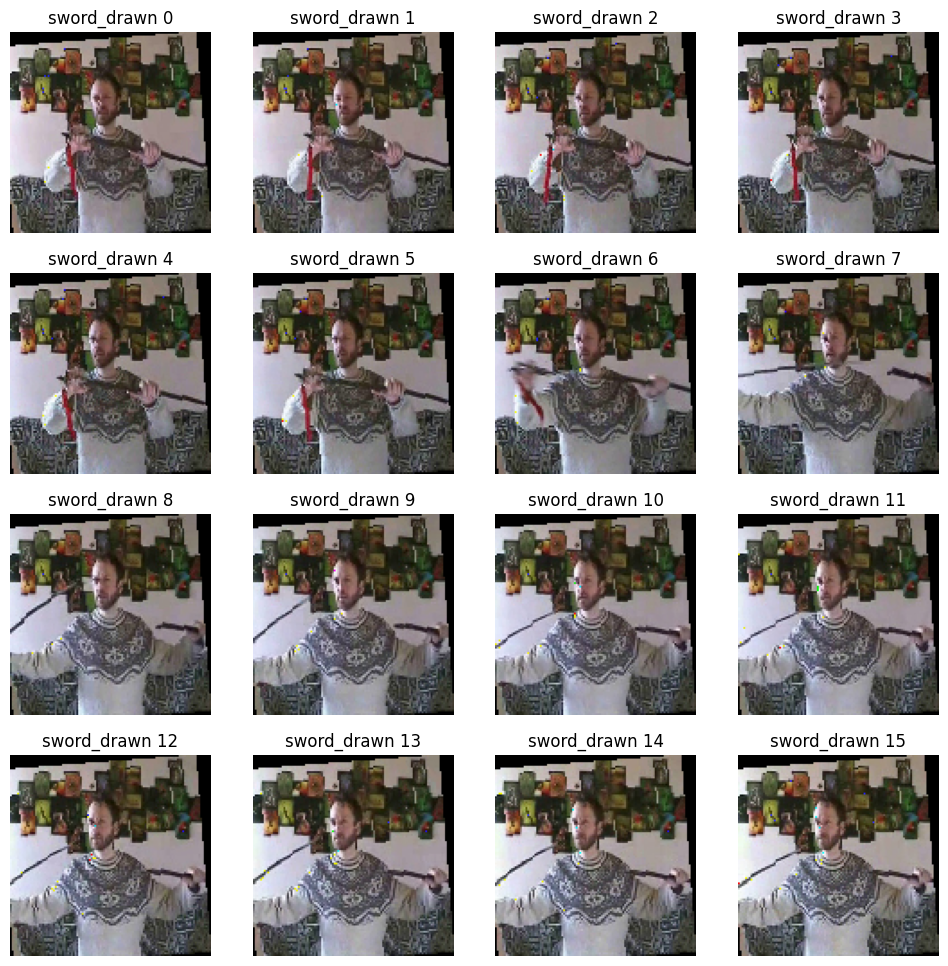

In [152]:
import matplotlib.pylab as plt
from torchvision.transforms.functional import to_pil_image

imgs, label = train_ds[5]

def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

plt.figure(figsize=(12, 12))
for ii, img in enumerate(imgs[:]):
    plt.subplot(4, 4, ii+1)
    plt.imshow(denormalize(img, [0.43216, 0.394666, 0.37645], [0.22803, 0.22145, 0.216989]))
    plt.title(list_classes[label] + " " + str(ii))
    plt.axis("off")

In [140]:
# Dataloaders
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)
for xb, yb in train_dl:
    print(type(xb), type(yb))  # <class 'torch.Tensor'> <class 'torch.Tensor'>
    print(xb.shape, yb.shape)  # 2, 16, 3, WIDTH, HEIGHT  # 2
    break

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([2, 16, 3, 112, 112]) torch.Size([2])


---

Let's now define the model architecture. The model is a 3D convolutional neural network (3dCNN) that is based on the [C3D](https://arxiv.org/abs/1412.0767) architecture. Although 3dCNNs are used here, you might want to use RNNs if you want to change it up. That being said, transfer learning might be a better option as it has been trained on a lot more data and the architecture is not a "random" one like we are going to do.


In [141]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [142]:
import torch.nn as nn

class ThreeDConvNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ThreeDConvNet, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3, 3, 3), padding=1)
        # The video is represented as a sequence of RGB frames, each frame can be considered as a 3-channel image (Red, Green, and Blue). 
        # A typical Conv3D network for video classification would have 3 input channels, one for each color channel, and the 3D convolution
        # operation performs over the spatial dimensions (height (WIDTH) and width (HEIGHT)) as well as the temporal dimension (time (16)).
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), padding=1)
        self.conv3 = nn.Conv3d(in_channels=128, out_channels=224, kernel_size=(3, 3, 3), padding=1)
        self.conv4 = nn.Conv3d(in_channels=224, out_channels=512, kernel_size=(3, 3, 3), padding=1)
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.relu = nn.ReLU()
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

        # add batch normalization after each convolutional layer
        self.bn1 = nn.BatchNorm3d(64)
        self.bn2 = nn.BatchNorm3d(128)
        self.bn3 = nn.BatchNorm3d(224)
        self.bn4 = nn.BatchNorm3d(512)
        # In some cases, batch normalization may not be beneficial or even harmful for a particular model.
        # One possible reason for this is that the batch size used during training can have an impact on the
        # effectiveness of batch normalization. If the batch size is too small, the batch statistics used for 
        # normalization can be noisy and not representative of the overall distribution of inputs to the layer.
        # In this case, when I tested it, batch normalization lead to over-regularization, which decreased accuracy.
        # But in general, batch normalization is a good practice to use, so you may find ways to make it work.
        
    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # x = self.bn1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # x = self.bn2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # x = self.bn3(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # x = self.bn4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  # This is a fully connected layer that takes the output of the adaptive average
        # pooling layer (which has 128 features) and produces a 2-dimensional output (corresponding to the predicted
        # class probabilities).
        return x

Let's train the model. We didn't make a validation set, this is not a good practice, but we are going to do it anyway. The biggest downside is that we won't be able to know if we are overfitting or not. You may want to make a validation set, especially if you want to play around with some hyperparameters (which surely are not optimal unless we're mad lucky).

Epoch: 1/50 [0/99]
Epoch: 1/50 [49/99]
Epoch: 1/50 Loss: 0.8035719072818757
Epoch: 2/50 [0/99]
Epoch: 2/50 [49/99]
Epoch: 2/50 Loss: 0.7021637898683548
Epoch: 3/50 [0/99]
Epoch: 3/50 [49/99]
Epoch: 3/50 Loss: 0.6700240057706833
Epoch: 4/50 [0/99]
Epoch: 4/50 [49/99]
Epoch: 4/50 Loss: 0.5481863030791283
Epoch: 5/50 [0/99]
Epoch: 5/50 [49/99]
Epoch: 5/50 Loss: 0.5456031352281571
Epoch: 6/50 [0/99]
Epoch: 6/50 [49/99]
Epoch: 6/50 Loss: 0.4796327332407236
Epoch: 7/50 [0/99]
Epoch: 7/50 [49/99]
Epoch: 7/50 Loss: 0.49083400789648296
Epoch: 8/50 [0/99]
Epoch: 8/50 [49/99]
Epoch: 8/50 Loss: 0.6638384890556336
Epoch: 9/50 [0/99]
Epoch: 9/50 [49/99]
Epoch: 9/50 Loss: 0.4545283895730972
Epoch: 10/50 [0/99]
Epoch: 10/50 [49/99]
Epoch: 10/50 Loss: 0.5404225139962364
Epoch: 11/50 [0/99]
Epoch: 11/50 [49/99]
Epoch: 11/50 Loss: 0.3890596415102482
Epoch: 12/50 [0/99]
Epoch: 12/50 [49/99]
Epoch: 12/50 Loss: 0.3661764989979565
Epoch: 13/50 [0/99]
Epoch: 13/50 [49/99]
Epoch: 13/50 Loss: 0.4060392415896058

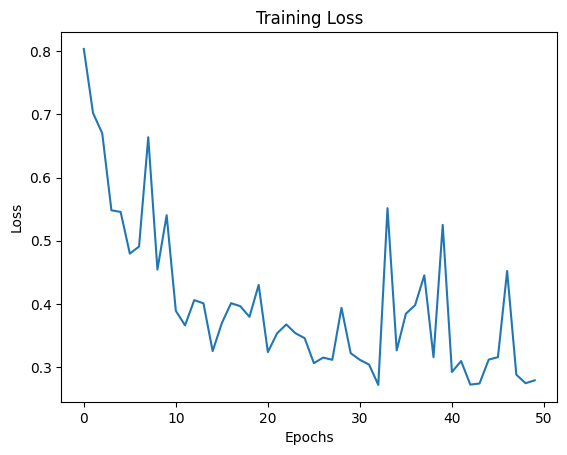

In [143]:
# Let's train the model
import torch.optim as optim

MODEL = ThreeDConvNet()
MODEL.to(DEVICE)
CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=0.0005)

def train(model, train_loader, criterion, optimizer, num_epochs):
    loss_list = []
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
            if batch_idx % 50 == 0 or batch_idx == len(train_loader)-1:
                print(f'Epoch: {epoch+1}/{num_epochs} [{batch_idx * len(data)}/{len(train_loader.dataset)}]')
        loss_list.append(np.mean(epoch_loss))
        print(f'Epoch: {epoch+1}/{num_epochs} Loss: {loss_list[-1]}')
    
    return loss_list
                
loss_list = train(MODEL, train_dl, CRITERION, OPTIMIZER, num_epochs=50)

# plot the loss
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

---
Let's predict the Kaggle test set


In [144]:
# Open the test set
PATH2TESTDATA = "./test_data"
SUB_FOLDER = "videos"
SUB_FOLDER_JPG = "frames"
path2vids = os.path.join(PATH2TESTDATA, SUB_FOLDER)

for files in os.listdir(path2vids):
    if os.path.splitext(files)[1] not in EXTENSIONS:
        print(f"{files} is not a video file. Skipping...")
        continue
    path2vid = os.path.join(path2vids, files)
    frames, vlen = get_frames(path2vid, n_frames = N_FRAMES)
    path2store = path2vid.replace(SUB_FOLDER, SUB_FOLDER_JPG)
    for extension in EXTENSIONS:
        path2store = path2store.replace(extension, "")
    os.makedirs(path2store, exist_ok= True)
    store_frames(frames, path2store)

.gitkeep is not a video file. Skipping...
swap.py is not a video file. Skipping...


In [145]:
# Load the data
def get_test_vids(path2data = "./test_data", sub_folder_jpg = "frames"):
    """
    :param path2data: path to data
    :param sub_folder_jpg: subfolder where the frames are stored

    :return: videos (selected frames), no list of labels (we don't have them, this is the test set), but the names of the videos
    """
    X = []
    vid_names = []
    path2frames = os.path.join(path2data, sub_folder_jpg)
    listofvids = os.listdir(path2frames)
    for video in listofvids:
        # looping over the videos
        vid_names.append(video)
        frames = []
        frame_names = os.listdir(os.path.join(path2frames, video))
        frame_names.sort(key=lambda x: int(re.findall(r'\d+', x)[0]))
        # otherwise the frames are not in the correct order (e.g. frame0.jpg, frame1.jpg, frame10.jpg, frame11.jpg, frame12.jpg,
        # frame13.jpg, frame14.jpg, frame15.jpg, frame2.jpg, frame3.jpg, frame4.jpg, frame5.jpg, frame6.jpg, frame7.jpg,
        # frame8.jpg, frame9.jpg) which ain't pretty
        for name in frame_names:
            # looping over the frames of the video
            if ".jpg" not in name:
                continue
            path2img = os.path.join(path2frames, video, name)
            img = cv2.imread(path2img)
            # OpenCV uses a default color representation of BGR (Blue, Green, Red) for images,
            # whereas PyTorch expects a color representation of RGB (Red, Green, Blue). 
            # This difference in color representation can cause the colors to appear weird or distorted in the frames.
            # To fix this issue, we can use the cv2.cvtColor() function in OpenCV to convert the color representation
            # of the frames from BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
            frames.append(img)
        if len(frames) != N_FRAMES:
            print(f'Warning: Could not extract all frames from video {video}')
            continue
        X.append(frames)
    return X, vid_names

In [146]:
X_test, vid_names_test = get_test_vids()

len(X_test), len(vid_names_test)

(296, 296)

In [147]:
# Predict the test set
test_transforms = ComposeCustom(
    [transforms.ToTensor(), transforms.Resize((WIDTH, HEIGHT))]
)

class TestVideoDataset(Dataset):
    def __init__(self, input_, transform=None):
        self.input_ = input_
        self.transform = transform
    
    def __len__(self):
        return len(self.input_)
    
    def __getitem__(self, idx):
        frames_tr = self.transform(self.input_[idx])  # Apply the same transformation to each frame
        frames_tr = torch.stack(frames_tr)  # Convert the list of transformed frames to a tensor
        return frames_tr

test_dataset = TestVideoDataset(X_test, transform=test_transforms)
test_dl = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [148]:
def predict(model, test_loader):
    model.eval()
    preds = []
    for batch_idx, data in enumerate(test_loader):
        print(f'Predicting batch {batch_idx+1}/{len(test_loader)}')
        data = data.to(DEVICE)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        preds += pred.tolist()
    return preds

preds = predict(MODEL, test_dl)

Predicting batch 1/148
Predicting batch 2/148
Predicting batch 3/148
Predicting batch 4/148
Predicting batch 5/148
Predicting batch 6/148
Predicting batch 7/148
Predicting batch 8/148
Predicting batch 9/148
Predicting batch 10/148
Predicting batch 11/148
Predicting batch 12/148
Predicting batch 13/148
Predicting batch 14/148
Predicting batch 15/148
Predicting batch 16/148
Predicting batch 17/148
Predicting batch 18/148
Predicting batch 19/148
Predicting batch 20/148
Predicting batch 21/148
Predicting batch 22/148
Predicting batch 23/148
Predicting batch 24/148
Predicting batch 25/148
Predicting batch 26/148
Predicting batch 27/148
Predicting batch 28/148
Predicting batch 29/148
Predicting batch 30/148
Predicting batch 31/148
Predicting batch 32/148
Predicting batch 33/148
Predicting batch 34/148
Predicting batch 35/148
Predicting batch 36/148
Predicting batch 37/148
Predicting batch 38/148
Predicting batch 39/148
Predicting batch 40/148
Predicting batch 41/148
Predicting batch 42/148
P

In [149]:
# Create the submission file
import pandas as pd

submission = pd.read_csv("./test_data/video_categories_sample_submission.csv", index_col=0)
# index_col=0 means that the first column of the csv file is the index, i.e. the video names
for idx, pred in enumerate(preds):
    submission.loc[vid_names_test[idx] + ".avi", "category"] = list_classes[pred[0]]

In [150]:
# Save the submission file
submission.to_csv("submission.csv", index=True)